In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import *
import numpy as np
#import peakutils

In [4]:
#bring in the summary table 
#format the date time inorder to merge with data files
summary_df = pd.read_csv("Data/3MTestingLog.csv")
summary_df = summary_df.drop(['Table Name'], axis=1)
summary_df["Install Date Time"] = pd.to_datetime(summary_df['Date'] + ' ' + summary_df['Install Time'], format="%m/%d/%y %H:%M")
summary_df["Removal Date Time"] = pd.to_datetime(summary_df['Date'] + ' ' + summary_df['Removal Time'], format="%m/%d/%y %H:%M")

summary_df

,Date,Filter ID,Install Time,Removal Time,Indoor Temp,Outdoor Temp,Outdoor RH,Pre 20x20x1,Post 20x20x1,Pre 14x24x1,Post 14x24x1,DAQ File,Install Date Time,Removal Date Time
0,11/20/19,FG-1,13:47,16:12,72,95,50,NaN,NaN,NaN,NaN,Data-20191120134426,2019-11-20 13:47:00,2019-11-20 16:12:00
1,11/20/19,FG-2,16:16,6:13,72,95,50,NaN,NaN,NaN,NaN,Data-20191120134426,2019-11-20 16:16:00,2019-11-20 06:13:00
2,11/21/19,MERV 8-1,8:02,10:18,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 08:02:00,2019-11-21 10:18:00
3,11/21/19,MERV 8-2,10:18,12:38,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 10:18:00,2019-11-21 12:38:00
4,11/21/19,1900-1,12:38,14:46,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 12:38:00,2019-11-21 14:46:00
5,11/21/19,1900-2,14:46,16:58,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 14:46:00,2019-11-21 16:58:00
6,11/21/19,MERV 8-4,16:58,5:30,72,95,50,7.1 oz.,7.1 oz.,7.5 oz.,7.5 oz.,"Data-20191121080221.dld.0000,1",2019-11-21 16:58:00,2019-11-21 05:30:00
7,11/22/19,MERV 8-5,7:51,10:04,72,95,50,7.2 oz.,7.25 oz.,7.55 oz.,7.55 oz.,Data-20191122074415,2019-11-22 07:51:00,2019-11-22 10:04:00
8,11/22/19,1900-4,10:04,13:00,72,95,50,8.55 oz.,8.55 oz.,8 oz.,7.55 oz.,Data-20191122074415,2019-11-22 10:04:00,2019-11-22 13:00:00
9,11/22/19,1900-5,13:00,15:32,72,95,50,8.6 oz.,8.6 oz.,8.05 oz.,8.05 oz.,Data-20191122074415,2019-11-22 13:00:00,2019-11-22 15:32:00


In [ ]:
summary_df.dtypes

In [5]:
#Bring in the testing data except for the first file
datafiles = ["Data/Data-20191121080221_0.csv", "Data/Data-20191121080221_1.csv", 
             "Data/Data-20191122074415.csv", "Data/Data-20191125071926_0.csv", "Data/Data-20191125071926_1.csv", 
             "Data/Data-20191126061705_0.csv", "Data/Data-20191126061705_1.csv", "Data/Data-20191127053638.csv"
            ]

usecols = ['Date', 'Time', "Volts", 'Volts.1', 'Amps', 'Amps.1', 'Watts']

In [6]:
#pullin the first file as a dataframe, pull the desired columns and drop the first row since there are two header rows
#Data1_df = pd.read_csv("Data/Data-20191120134426.csv", skiprows=0, usecols=usecols)

#Data1_df = pd.read_csv("Data/Data-20191120134426.csv", skiprows=1, usecols=usecols) 

Data1_df = pd.read_csv("Data/Data-20191120134426.csv", skiprows=1, usecols=usecols) 

#remove all of the rows with zeros
AllData_df = Data1_df.loc[(Data1_df['Watts']!=0)]

AllData_df.shape

/Users/abby/miniconda3/envs/PythonData/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(58984, 7)

In [1]:
AllData_df.dtypes

NameError: name 'AllData_df' is not defined

In [7]:
#pull in all of the other data files and create one large file while removing all zero values
for file in datafiles:
    Data2_df = pd.read_csv(file, skiprows=1, usecols=usecols)

    #NonZeroData2_df = Data2_df[(Data2_df != 0).all(1)]
    #df.loc[~(df==0).all(axis=1)]
    NonZeroData2_df = Data2_df.loc[(Data2_df['Watts']!=0)]
        
    AllData_df = AllData_df.append(NonZeroData2_df, ignore_index=True)
    
AllData_df['Date and Time'] = pd.to_datetime(AllData_df['Date'] + ' ' + AllData_df['Time'], format="%Y/%m/%d %H:%M:%S")

AllData_df.shape

(357325, 8)

In [ ]:
#AllData_df['Date and Time'] = pd.to_datetime(AllData_df['Date'] + ' ' + AllData_df['Time'], format="%Y/%m/%d %H:%M:%S")
#AllData_df['Date and Time'] = pd.to_datetime(AllData_df['Date'] + ' ' + AllData_df['Time'])

ZeroData_df = AllData_df.loc[AllData_df['Watts'] == 0]

ZeroData_df.shape

In [ ]:
# #create new columns in AllData_df by using conditional (mask) and data from summary_df
# #without adding column combining date and time

# for i in range(len(summary_df['Filter ID'])):
#     mask = (AllData_df['Date'] == summary_df['Date'][i]) & (AllData_df['Time'] >= summary_df['Install Time'][i]) & (AllData_df['Time'] <= summary_df['Removal Time'][i])
    
#     AllData_df.loc[mask, 'Filter ID'] = summary_df['Filter ID'][i]
#     AllData_df.loc[mask, 'Outdoor Temp'] = summary_df['Outdoor Temp'][i]
#     if summary_df['Pre 20x20x1'][i] == 'N/A':
#         AllData_df.loc[mask, 'Clean/Dirty'] = 'Clean'
#     else:
#         AllData_df.loc[mask, 'Clean/Dirty'] = 'Dirty'
        
# FilteredData_df = AllData_df.dropna()
# FilteredData_df.shape

In [33]:
#create new columns in AllData_df by using conditional (mask) and data from summary_df
#with using the combined column date and time

for i in range(len(summary_df['Filter ID'])-1):
    mask = (AllData_df['Date and Time'] >= summary_df['Install Date Time'][i]) & (AllData_df['Date and Time'] <= summary_df['Removal Date Time'][i])

    AllData_df.loc[mask, 'Filter ID'] = summary_df['Filter ID'][i]
    AllData_df.loc[mask, 'Outdoor Temp'] = summary_df['Outdoor Temp'][i]
    if (summary_df['Filter ID'][i]=='MERV 8-4') | (summary_df['Filter ID'][i]=='MERV 8-5') | (summary_df['Filter ID'][i]=='1900-4') | (summary_df['Filter ID'][i]=='1900-5'):
        AllData_df.loc[mask, 'Clean/Dirty'] = 'Dirty'
    else:
        AllData_df.loc[mask, 'Clean/Dirty'] = 'Clean'

FilteredData_df = AllData_df.dropna()
FilteredData_df

,Date,Time,Volts,Volts.1,Amps,Amps.1,Watts,Date and Time,Filter ID,Outdoor Temp,Clean/Dirty
154,2019/11/20,13:47:00,121.7,121.6,3.8,4.35,988.6,2019-11-20 13:47:00,FG-1,95.0,Clean
155,2019/11/20,13:47:01,121.7,121.5,3.8,4.35,988.0,2019-11-20 13:47:01,FG-1,95.0,Clean
156,2019/11/20,13:47:02,121.6,121.5,3.8,4.35,987.1,2019-11-20 13:47:02,FG-1,95.0,Clean
157,2019/11/20,13:47:03,121.6,121.5,3.8,4.35,986.1,2019-11-20 13:47:03,FG-1,95.0,Clean
158,2019/11/20,13:47:04,121.6,121.5,3.8,4.35,988.3,2019-11-20 13:47:04,FG-1,95.0,Clean
...,...,...,...,...,...,...,...,...,...,...,...
343084,2019/11/27,08:52:56,121.4,121.2,1.6,0.62,241.1,2019-11-27 08:52:56,1900-4,40.0,Dirty
343085,2019/11/27,08:52:57,121.3,121.2,1.6,0.62,241.0,2019-11-27 08:52:57,1900-4,40.0,Dirty
343086,2019/11/27,08:52:58,121.3,121.2,1.6,0.62,240.9,2019-11-27 08:52:58,1900-4,40.0,Dirty
343087,2019/11/27,08:52:59,121.3,121.2,1.6,0.62,240.5,2019-11-27 08:52:59,1900-4,40.0,Dirty


In [34]:
#confirming that the Watts column is Volts+Volts.1 * Amps+Amps.1

CalculatedColumns_df = FilteredData_df.copy()
CalculatedColumns_df['Calculated Energy (kJ)'] = ((CalculatedColumns_df['Volts']+CalculatedColumns_df['Volts.1']) * (CalculatedColumns_df['Amps']+CalculatedColumns_df['Amps.1']))/1000
#ConfirmWatts_df['Diff in Watts'] = ConfirmWatts_df['Watts'] - ConfirmWatts_df['Watts Confirmed']
CalculatedColumns_df

,Date,Time,Volts,Volts.1,Amps,Amps.1,Watts,Date and Time,Filter ID,Outdoor Temp,Clean/Dirty,Calculated Energy (kJ)
154,2019/11/20,13:47:00,121.7,121.6,3.8,4.35,988.6,2019-11-20 13:47:00,FG-1,95.0,Clean,1.982895
155,2019/11/20,13:47:01,121.7,121.5,3.8,4.35,988.0,2019-11-20 13:47:01,FG-1,95.0,Clean,1.982080
156,2019/11/20,13:47:02,121.6,121.5,3.8,4.35,987.1,2019-11-20 13:47:02,FG-1,95.0,Clean,1.981265
157,2019/11/20,13:47:03,121.6,121.5,3.8,4.35,986.1,2019-11-20 13:47:03,FG-1,95.0,Clean,1.981265
158,2019/11/20,13:47:04,121.6,121.5,3.8,4.35,988.3,2019-11-20 13:47:04,FG-1,95.0,Clean,1.981265
...,...,...,...,...,...,...,...,...,...,...,...,...
343084,2019/11/27,08:52:56,121.4,121.2,1.6,0.62,241.1,2019-11-27 08:52:56,1900-4,40.0,Dirty,0.538572
343085,2019/11/27,08:52:57,121.3,121.2,1.6,0.62,241.0,2019-11-27 08:52:57,1900-4,40.0,Dirty,0.538350
343086,2019/11/27,08:52:58,121.3,121.2,1.6,0.62,240.9,2019-11-27 08:52:58,1900-4,40.0,Dirty,0.538350
343087,2019/11/27,08:52:59,121.3,121.2,1.6,0.62,240.5,2019-11-27 08:52:59,1900-4,40.0,Dirty,0.538350


In [35]:
#playing with groupby()

Grouped_df = CalculatedColumns_df.groupby(['Outdoor Temp','Clean/Dirty','Filter ID'])
GroupKeys = Grouped_df.groups.keys()
Grouped_df.count()

Date   Time  Volts  Volts.1   Amps  \
Outdoor Temp Clean/Dirty Filter ID                                        
40.0         Clean       1900-1     11880  11880  11880    11880  11880   
                         1900-2     12000  12000  12000    12000  12000   
                         FG-1        8520   8520   8520     8520   8520   
                         FG-2       14580  14580  14580    14580  14580   
                         MERV 8-1   14341  14341  14341    14341  14341   
             Dirty       1900-4     11641  11641  11641    11641  11641   
                         MERV 8-4   13441  13441  13441    13441  13441   
95.0         Clean       1900-1      7680   7680   7680     7680   7680   
                         1900-2      7921   7921   7921     7921   7921   
                         FG-1        8701   8701   8701     8701   8701   
                         MERV 8-1    8139   8139   8139     8139   8139   
                         MERV 8-2    8400   8400   8400     8400   8400   
             Dirty       1900-4     10560  10560  10560    10560  10560   
                         1900-5      9121   9121   9121     9121   9121   
                         MERV 8-5    7980   7980   7980     7980   7980   

                                    Amps.1  Watts  Date and Time  \
Outdoor Temp Clean/Dirty Filter ID                                 
40.0         Clean       1900-1      11880  11880          11880   
                         1900-2      12000  12000          12000   
                         FG-1         8520   8520           8520   
                         FG-2        14580  14580          14580   
                         MERV 8-1    14341  14341          14341   
             Dirty       1900-4      11641  11641          11641   
                         MERV 8-4    13441  13441          13441   
95.0         Clean       1900-1       7680   7680           7680   
                         1900-2       7921   7921           7921   
                         FG-1         8701   8701           8701   
                         MERV 8-1     8139   8139           8139   
                         MERV 8-2     8400   8400           8400   
             Dirty       1900-4      10560  10560          10560   
                         1900-5       9121   9121           9121   
                         MERV 8-5     7980   7980           7980   

                                    Calculated Energy (kJ)  
Outdoor Temp Clean/Dirty Filter ID                          
40.0         Clean       1900-1                      11880  
                         1900-2                      12000  
                         FG-1                         8520  
                         FG-2                        14580  
                         MERV 8-1                    14341  
             Dirty       1900-4                      11641  
                         MERV 8-4                    13441  
95.0         Clean       1900-1                       7680  
                         1900-2                       7921  
                         FG-1                         8701  
                         MERV 8-1                     8139  
                         MERV 8-2                     8400  
             Dirty       1900-4                      10560  
                         1900-5                       9121  
                         MERV 8-5                     7980

In [ ]:
#Create a column measuring the time that each filter was tested for
    
timecount = Grouped_df['Time'].count()
timecount

CalculatedColumns_df.cumsum()


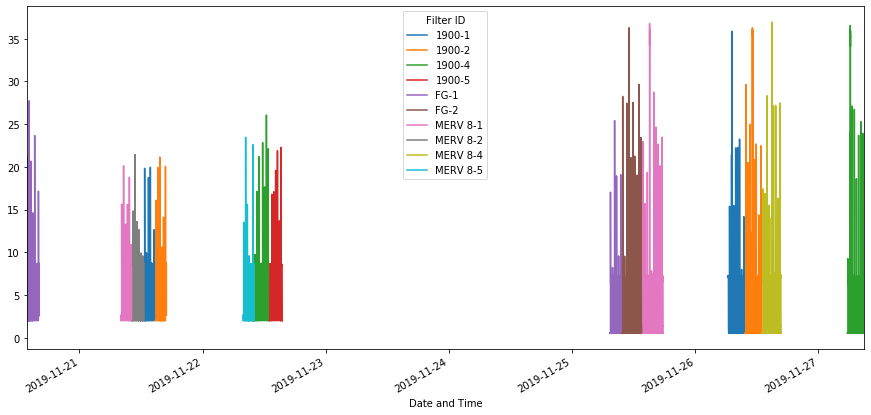

In [15]:
#playing with plotting the data

# df.set_index('Date', inplace=True)
# df.groupby('ticker')['adj_close'].plot(legend=True)

#FilteredData_df.set_index('Date and Time', inplace=True)
#CalculatedColumns_df.groupby(['Outdoor Temp', 'Filter ID'])['Calculated Energy (kJ)'].plot(legend=True)

#Ploting multipule lines on one graph
# fig, ax = plt.subplots(figsize=(15,7))
# data.groupby(['date','type']).count()['amount'].unstack().plot(ax=ax)
# ax.set_xlabel('Date')
# ax.set_ylabel('Number of transactions')

fig, ax = plt.subplots(figsize=(15,7))
CalculatedColumns_df.groupby(['Date and Time', 'Filter ID']).mean()['Calculated Energy (kJ)'].unstack().plot(ax=ax)



#Grouped_df.plot(use_index=True, y='Calculated Energy (kJ)', color='red')
#plt.savefig("Images/Groupedby_HeatingandCooling_FilterID.png")
#plt.show()

In [ ]:
#find the baseline in the data

baseline_values = peakutils.baseline(Grouped_df['Calculated Energy (kJ)'])
baseline_values